In [7]:
from transformers import BertTokenizer, BertModel

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

from dataset import Dataset

import sys
import numpy as np
import pickle

np.set_printoptions(threshold=sys.maxsize)

In [8]:
processed_train_path = "../data/pre_processed/"
train_dataset = Dataset(processed_train_path)

In [9]:
processed_train_path = "../data/test_pre_processed/"
test_dataset = Dataset(processed_train_path)

# CNN training

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


class CNN_Text(nn.Module):
    
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout):
        super(CNN_Text, self).__init__()
        
        V = embed_num
        D = embed_dim
        C = class_num
        Ci = 1
        Co = kernel_num
        Ks = kernel_sizes

#         self.embed = nn.Embedding(V, D)
        self.convs = nn.ModuleList([nn.Conv2d(Ci, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)



    def forward(self, x):
#         x = self.embed(x)  # (N, W, D)
    
        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [torch.tanh(conv(x)).squeeze(3) for conv in self.convs]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)

        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        return logit

In [12]:
# initialize model
device = "cuda" if torch.cuda.is_available() else "cpu"
# cnn_model = KimCNN()


n_epochs = 100
lr = 0.001

kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5

cnn_classifier = CNN_Text(
    embed_dim=768,
    embed_num=512,
    class_num=6,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout
).to(device)

optimizer = torch.optim.Adam(cnn_classifier.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss().to(device)

In [13]:
print(cnn_classifier)

CNN_Text(
  (convs): ModuleList(
    (0): Conv2d(1, 3, kernel_size=(2, 768), stride=(1, 1))
    (1): Conv2d(1, 3, kernel_size=(3, 768), stride=(1, 1))
    (2): Conv2d(1, 3, kernel_size=(4, 768), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9, out_features=6, bias=True)
)


In [14]:

import numpy as np
import matplotlib.pyplot as plt
import time

def pltsin(ax, x_train, x_test, y_train, y_test, ydatacolors=['b','r']):

    y = np.random.random(size=(100,1))
    ax.plot(x_train, y_train, ydatacolors[0])
    ax.plot(x_test, y_test, ydatacolors[1])
    fig.canvas.draw()

In [20]:
import ipdb

def get_accuracy(output, targets):
    _, indices = output.max(1)
    accuracy = sum(indices == targets)
    return accuracy

<IPython.core.display.Javascript object>


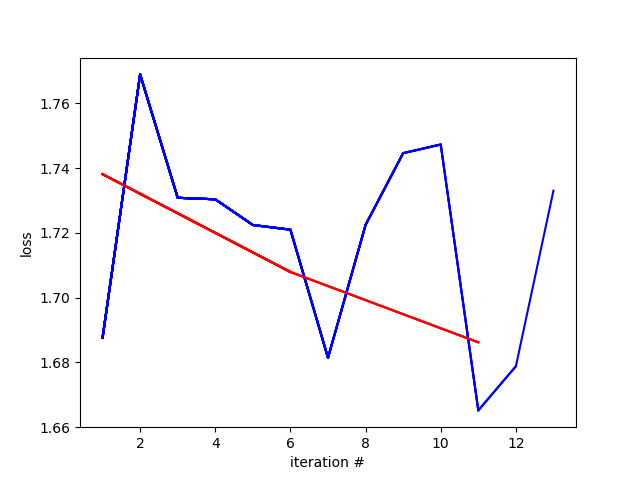

Current epoch 0 out of 100 
Epoch: [0/100] batch: [0/19] Train loss: 1.760259747505188 Validation loss: 1.3904820680618286 Validation accuracy 13.8
Epoch: [0/100] batch: [1/19] Train loss: 1.768910527229309 Validation loss: 1.3904820680618286 Validation accuracy 13.8
Epoch: [0/100] batch: [2/19] Train loss: 1.7308170795440674 Validation loss: 1.3904820680618286 Validation accuracy 13.8
Epoch: [0/100] batch: [3/19] Train loss: 1.7303539514541626 Validation loss: 1.3904820680618286 Validation accuracy 13.8
Epoch: [0/100] batch: [4/19] Train loss: 1.7224193811416626 Validation loss: 1.3904820680618286 Validation accuracy 13.8
Epoch: [0/100] batch: [5/19] Train loss: 1.7303296327590942 Validation loss: 1.366330862045288 Validation accuracy 13.6
Epoch: [0/100] batch: [6/19] Train loss: 1.681410551071167 Validation loss: 1.366330862045288 Validation accuracy 13.6
Epoch: [0/100] batch: [7/19] Train loss: 1.722456455230713 Validation loss: 1.366330862045288 Validation accuracy 13.6
Epoch: [0/1

In [ ]:
%matplotlib notebook
fig,ax = plt.subplots(1,1)
ax.set_xlabel('iteration #')
ax.set_ylabel('loss')
# ax.axis(xmin=0, xmax=None, ymin=0, ymax=None)

train_plot_x = []
train_plot_y = []
test_plot_x  = []
test_plot_y  = []
iteration = 0

for epoch in range(n_epochs):
    train_loss = 0
    print(f"Current epoch {epoch} out of {n_epochs} ")
    for file_index in range(len(train_dataset)-1):
        iteration += 1

        batch, labels = train_dataset[file_index]

        _, indices = labels.max(1)
            
        optimizer.zero_grad()
        cnn_classifier.train()

        output = cnn_classifier(batch.float().to(device))
        output = output.reshape(batch.shape[0], 6)
    
        loss = loss_fn(output, indices.to(device))
        
        train_plot_x.append(iteration)
        train_plot_y.append(loss.detach().cpu())

        loss.backward()
        optimizer.step()
        
        if not file_index % 5:
            cnn_classifier.eval()
            test_loss = 0
            accuracy = 0
            for test_index in range(len(test_dataset)-1):
                test_batch, test_labels = test_dataset[test_index]
                _, test_indices = test_labels.max(1)
                output = cnn_classifier(test_batch.float().to(device))
                output = output.reshape(test_batch.shape[0], 6)
                loss = loss_fn(output, test_indices.to(device))
                test_loss += loss.detach().cpu()
                
                accuracy += get_accuracy(output.detach().cpu(), test_indices.cpu()).item()
            
            test_plot_x.append(iteration)
            test_plot_y.append(test_loss/(len(test_dataset)-1))
            cnn_classifier.train()


        print(f'Epoch: [{epoch}/{n_epochs}] batch: [{file_index}/{len(train_dataset)-1}] Train loss: {loss} Validation loss: {test_loss/(len(test_dataset))} Validation accuracy {accuracy/(len(test_dataset))}')
        pltsin(ax, train_plot_x, test_plot_x, train_plot_y, test_plot_y, ['b', 'r'])
    torch.save(cnn_classifier.state_dict(), f"cnn_models/model_epoch_{epoch}.p")
